In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from dataset import LayoutDataset
from models import LayoutMLP
from scipy.stats import kendalltau

2023-11-14 22:25:52.830501: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 22:25:54.053222: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 128
dataset_take = 7500
learning_rate = 1.5e-3
batch_per_file_size = 8
node_embedding_size = 16
layers = [140, 70, 36, 40, 26]

dataset = LayoutDataset(
    batch_size, dataset_take,
    build_tfrecords=False,
    batch_per_file_size=batch_per_file_size
)

2023-11-14 22:25:57.036040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 22:25:57.137455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 22:25:57.137699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

train layout:nlp:default 7500 False
train layout:nlp:random 7500 False
train layout:xla:random 7500 True
train layout:xla:default 7500 True
test all_filenames 10000 False
valid all_filenames 1000 False


In [3]:
mlp = LayoutMLP(
    batch_size,
    learning_rate=learning_rate,
    batch_per_file_size=batch_per_file_size,
    node_embedding_size=node_embedding_size,
    validation_frequency=10_000,
    validations_without_improvement=5,
    layer_sizes=layers,
    loss='pairwise_hinge',
    n_siblings=dataset.n_siblings,
    l1_multiplier=2e-8,
    output_name='layout_11_14_22_30'
)

In [4]:
mlp.train(dataset, None)

2023-11-14 22:25:58.660505: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 76288000 exceeds 10% of free system memory.
2023-11-14 22:25:58.787388: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 73216000 exceeds 10% of free system memory.
2023-11-14 22:25:59.010791: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 76288000 exceeds 10% of free system memory.
2023-11-14 22:25:59.308263: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 76288000 exceeds 10% of free system memory.
2023-11-14 22:25:59.373477: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 36864000 exceeds 10% of free system memory.
2023-11-14 22:28:36.643517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-14 22:28:36.673801: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f845004a8c0 initialized for p

iteration 500 training loss 3.3151348 lr 0.00007
iteration 1000 training loss 2.7798276 lr 0.00015
iteration 1500 training loss 2.4689615 lr 0.00022
iteration 2000 training loss 1.9469544 lr 0.00030
iteration 2500 training loss 2.3723025 lr 0.00037
iteration 3000 training loss 2.1507165 lr 0.00045
iteration 3500 training loss 2.2486129 lr 0.00052
iteration 4000 training loss 2.0951169 lr 0.00060
iteration 4500 training loss 2.2845707 lr 0.00067
iteration 5000 training loss 1.9572066 lr 0.00075
iteration 5500 training loss 2.2576175 lr 0.00082
iteration 6000 training loss 1.9855896 lr 0.00090
iteration 6500 training loss 2.1695392 lr 0.00097
iteration 7000 training loss 1.6592286 lr 0.00105
iteration 7500 training loss 1.9338281 lr 0.00112
iteration 8000 training loss 1.6964661 lr 0.00120
iteration 8500 training loss 2.2549465 lr 0.00127
iteration 9000 training loss 1.2554336 lr 0.00135
iteration 9500 training loss 1.5744137 lr 0.00142
iteration 10000 training loss 1.5487736 lr 0.00150


iteration 70000 training loss 0.9372304 lr 0.00131
layout:nlp:random 0.9211046801093076
layout:nlp:default 0.4893073002755795
layout:xla:random 0.6663409393787563
layout:xla:default 0.3448723479991271
epoch 0, it 70000 validation loss -0.605
iteration 70500 training loss 1.1252923 lr 0.00130
iteration 71000 training loss 1.4731514 lr 0.00130
iteration 71500 training loss 0.8524055 lr 0.00130
iteration 72000 training loss 1.0159317 lr 0.00129
iteration 72500 training loss 0.8662552 lr 0.00129
iteration 73000 training loss 0.87424636 lr 0.00129
iteration 73500 training loss 0.94273025 lr 0.00128
iteration 74000 training loss 0.89962286 lr 0.00128
iteration 74500 training loss 1.1412958 lr 0.00128
iteration 75000 training loss 1.5146346 lr 0.00128
iteration 75500 training loss 1.2554556 lr 0.00127
iteration 76000 training loss 1.1207812 lr 0.00127
iteration 76500 training loss 0.9720813 lr 0.00127
iteration 77000 training loss 1.115592 lr 0.00126
iteration 77500 training loss 1.2369038 lr

iteration 136500 training loss 1.1857076 lr 0.00077
iteration 137000 training loss 0.9293848 lr 0.00077
iteration 137500 training loss 0.6368624 lr 0.00077
iteration 138000 training loss 1.2531412 lr 0.00076
iteration 138500 training loss 1.1033224 lr 0.00076
iteration 139000 training loss 1.4272888 lr 0.00075
iteration 139500 training loss 0.7472291 lr 0.00075
iteration 140000 training loss 0.6529924 lr 0.00074
layout:nlp:random 0.9296013568500865
layout:nlp:default 0.4963628453116626
layout:xla:random 0.6598707875631739
layout:xla:default 0.36816758054211446
epoch 0, it 140000 validation loss -0.614
iteration 140500 training loss 1.3907772 lr 0.00074
iteration 141000 training loss 0.92439026 lr 0.00073
iteration 141500 training loss 1.2968522 lr 0.00073
iteration 142000 training loss 0.8408058 lr 0.00072
iteration 142500 training loss 0.8040542 lr 0.00072
iteration 143000 training loss 1.0576776 lr 0.00072
iteration 143500 training loss 0.8707342 lr 0.00071
iteration 144000 training 

In [5]:
mlp.best_val_subsets

{'layout:nlp:random': 0.936422516342936,
 'layout:nlp:default': 0.5005782226238036,
 'layout:xla:random': 0.6675391429272413,
 'layout:xla:default': 0.3886512999845698}

In [6]:
np.mean(list(mlp.best_val_subsets.values()))

0.6232977954696377

## Evaluate validation set

In [7]:
val_df = mlp.predict_over_dataset(dataset.valid_data, return_labels=True)

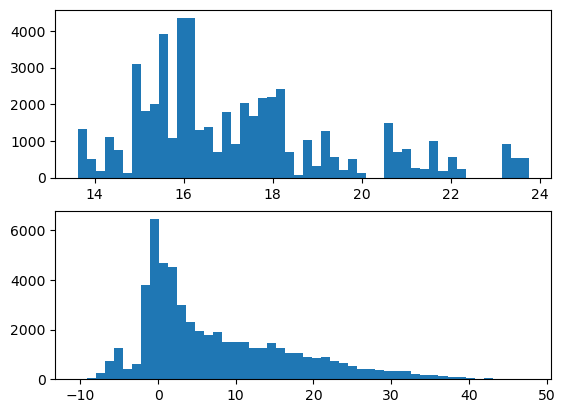

In [8]:
plt.subplot(2, 1, 1)
plt.hist(val_df['target'], bins=50)
plt.subplot(2, 1, 2)
plt.hist(val_df['prediction'], bins=50);

In [9]:
val_df.groupby('ID').apply(lambda x: x.min()).sort_values('prediction')

,ID,config_index,prediction,target
ID,,,,
b'layout:xla:random:resnet_v1_50_official_batch_128_bf16',b'layout:xla:random:resnet_v1_50_official_batc...,19,-10.337190,20.910173
b'layout:xla:default:resnet_v1_50_official_batch_128_bf16',b'layout:xla:default:resnet_v1_50_official_bat...,18,-9.700647,20.910114
b'layout:xla:default:tf2_bert_pretrain_dynamic_batch_size',b'layout:xla:default:tf2_bert_pretrain_dynamic...,25,-6.930523,17.943745
b'layout:xla:default:bert_pretraining.4x4.fp16',b'layout:xla:default:bert_pretraining.4x4.fp16',24,-6.758962,17.647287
b'layout:xla:random:resnet50.4x4.fp16',b'layout:xla:random:resnet50.4x4.fp16',15,-5.790600,19.288380
b'layout:xla:default:resnet50.4x4.fp16',b'layout:xla:default:resnet50.4x4.fp16',4,-5.751441,19.288345
b'layout:xla:random:bert_pretraining.4x4.fp16',b'layout:xla:random:bert_pretraining.4x4.fp16',9,-5.734766,17.647587
b'layout:xla:random:tf2_bert_pretrain_dynamic_batch_size',b'layout:xla:random:tf2_bert_pretrain_dynamic_...,14,-5.307144,17.944567
b'layout:nlp:random:small_bert_bert_en_uncased_L-12_H-768_A-12_batch_size_64_train',b'layout:nlp:random:small_bert_bert_en_uncased...,7,-4.287951,18.142097


Text(0.5, 1.0, "b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-512_A-8_batch_size_64_test'")

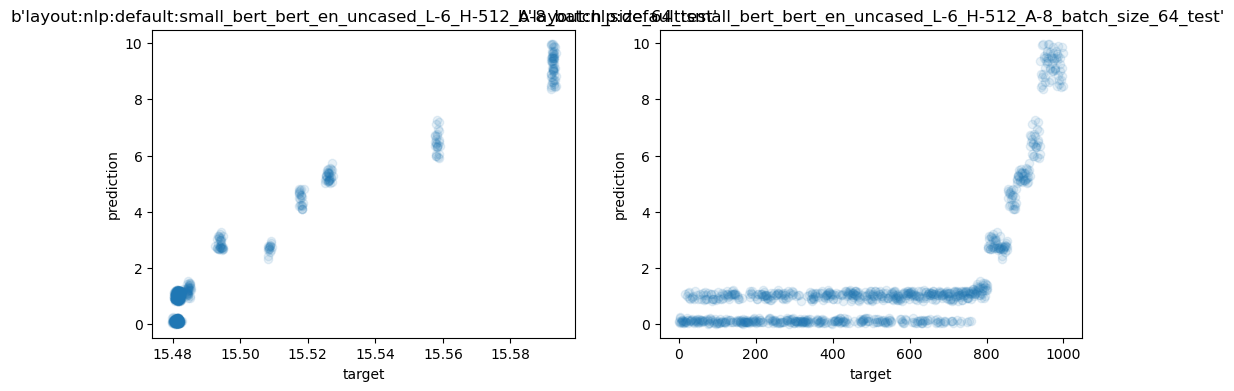

In [28]:
x_lin = np.linspace(15, 25, 100)
#plt.plot(x_lin, x_lin, color='orange')

random_sample = val_df.sample(1_000)
graph_id = np.random.choice(val_df['ID'].unique())
#graph_id = b'layout:xla:default:inception_v3_batch_128_train'
#graph_id = b'layout:xla:default:unet_3d.4x4.bf16'
random_sample = val_df[val_df['ID'] == graph_id].copy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample.target,
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

random_sample.sort_values('target', inplace=True)
plt.subplot(1, 2, 2)
plt.scatter(
    np.arange(len(random_sample)),
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

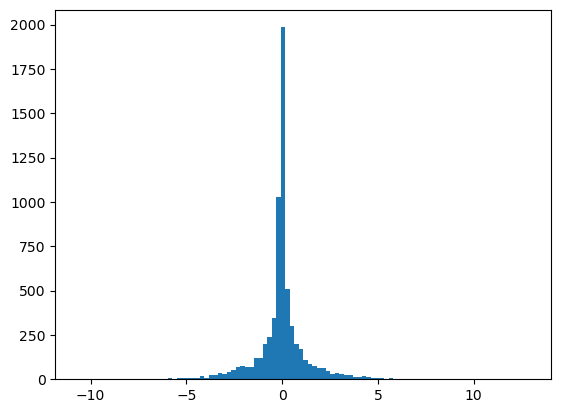

In [30]:
plt.hist(mlp.dense_layer_global_1.kernel.numpy().flatten(), bins=100);

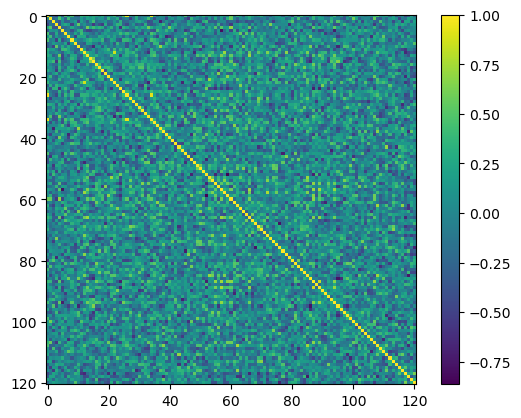

In [12]:
emb = mlp.embedding_layer_node_ops.weights[0].numpy()
emb = emb / np.expand_dims(np.linalg.norm(emb, axis=1), axis=-1)
dots = np.matmul(emb, emb.T)
plt.imshow(dots)
plt.colorbar()

In [32]:
ind = np.unravel_index(np.argsort(dots.flatten())[-127], dots.shape)
ind

(26, 34)

In [ ]:
val_df[val_df['ID'] == b'layout:xla:default:unet_3d.4x4.bf16'].sort_values('target')

In [ ]:
for val_batch in dataset.valid_data:
    if b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy():
        print(val_batch['layout_id'])
        break

In [ ]:
np.unique(val_batch['layout_id'].numpy())

In [ ]:
b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy()

In [ ]:
random_sample = val_df.sample(5_000)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample['target'],
    np.abs(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('abs error')
x_lin = np.linspace(0, 0.7, 100)
#plt.plot(x_lin, x_lin, color='orange')


plt.subplot(1, 2, 2)
plt.scatter(
    random_sample['target'],
    np.square(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('squared error')

In [33]:
def sort_configs(df):
    top = df.sort_values('prediction')
    top = top['config_index'].values.tolist()
    top = [str(i) for i in top]
    return ';'.join(top)

In [34]:
val_prediction = val_df.groupby('ID').apply(sort_configs)
val_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
val_prediction

ID
layout:nlp:default:albert_en_xlarge_batch_size_16_test                               25152;25326;37640;37660;18915;29995;9514;32912...
layout:nlp:default:bert_en_cased_L-12_H-768_A-12_batch_size_16_test                  55768;87602;52061;41123;41078;40350;20786;8550...
layout:nlp:default:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train              22931;28098;8029;15087;22959;22842;8096;8073;1...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_32_test      99043;3951;53021;61033;4953;56782;81000;55905;...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train     40479;50184;40478;50237;30562;35234;48565;3062...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_32_test      42054;7319;28010;7252;7231;7220;8710;73184;730...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train     31312;38472;36171;38466;15360;36170;38445;1536...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H

In [35]:
val_df

,ID,config_index,prediction,target
0,b'layout:nlp:default:small_bert_bert_en_uncase...,1783,-0.428425,16.525152
1,b'layout:xla:random:mlperf_bert_batch_24_2x2',2166,5.765773,23.605322
2,b'layout:nlp:default:small_bert_bert_en_uncase...,45141,1.624900,15.973487
3,b'layout:xla:default:unet_3d.4x4.bf16',1071,1.855903,20.645973
4,b'layout:xla:random:inception_v3_batch_128_train',4481,11.260245,22.211166
...,...,...,...,...
53476,b'layout:nlp:random:small_bert_bert_en_uncased...,11217,5.679019,15.915776
53477,b'layout:nlp:default:small_bert_bert_en_uncase...,18622,-0.133982,16.078899
53478,b'layout:nlp:random:small_bert_bert_en_uncased...,6236,5.068996,15.355140
53479,b'layout:nlp:default:small_bert_bert_en_uncase...,4051,3.820794,17.047108


In [36]:
val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3])).unique()

array(['layout:nlp:default', 'layout:xla:random', 'layout:xla:default',
       'layout:nlp:random'], dtype=object)

In [37]:
def compute_layout_score_group(df):
    score, _ = kendalltau(df['prediction'], df['target'])
    return score

val_df['subset'] = val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
all_means = []
for subset in val_df['subset'].unique():
    mean = np.mean(val_df[val_df['subset'] == subset].groupby('ID').apply(compute_layout_score_group))
    all_means.append(mean)
    print(subset, mean)
print(np.mean(all_means))

layout:nlp:default 0.5005782226238036
layout:xla:random 0.6477921570003501
layout:xla:default 0.37376803751790344
layout:nlp:random 0.936422516342936
0.6146402333712484


In [ ]:
np.mean([
    0.9235,
    0.6591,
    0.516,
    0.358,
    0.968
])

In [38]:
val_scores = val_df.groupby('ID').apply(compute_layout_score_group)
val_scores.sort_values()

ID
b'layout:xla:default:unet_3d.4x4.bf16'                                                 -0.029707
b'layout:xla:random:unet_3d.4x4.bf16'                                                   0.136415
b'layout:xla:default:mlperf_bert_batch_24_2x2'                                          0.297292
b'layout:xla:default:tf2_bert_pretrain_dynamic_batch_size'                              0.349348
b'layout:nlp:default:small_bert_bert_en_uncased_L-4_H-512_A-8_batch_size_32_train'      0.399004
b'layout:nlp:default:albert_en_xlarge_batch_size_16_test'                               0.411495
b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_64_train'      0.427040
b'layout:xla:random:mlperf_bert_batch_24_2x2'                                           0.438110
b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train'      0.462222
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-512_A-8_batch_size_64_test'      0.464177
b'layout:nlp:default:bert_m

In [ ]:
valid_nodes_list = []
for batch in dataset.valid_data:
    df = pd.DataFrame(
        np.stack([
            batch['layout_id'].numpy(), 
            batch['valid_nodes'].numpy()], axis=-1),
        columns=['ID', 'valid_nodes']
    ).drop_duplicates('ID')
    valid_nodes_list.append(df)
valid_nodes = pd.concat(valid_nodes_list).drop_duplicates('ID')
valid_nodes

In [ ]:
valid_nodes.set_index('ID', inplace=True)
valid_nodes['scores'] = val_scores
valid_nodes

In [ ]:
valid_nodes.reset_index(inplace=True)
valid_nodes

In [ ]:
valid_nodes['subset'] = valid_nodes['ID'].apply(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
valid_nodes

In [ ]:
plt.scatter(
    valid_nodes['scores'],
    valid_nodes['valid_nodes']
)

In [ ]:
subset = 'layout:xla:random'
valid_nodes_subset = valid_nodes[valid_nodes['subset'] == subset]
print(valid_nodes_subset.sort_values('valid_nodes').iloc[-1])
plt.scatter(
    valid_nodes_subset['scores'],
    valid_nodes_subset['valid_nodes']
)

In [ ]:
def layout_score(candidate_order, layout_dict):
    runtimes = layout_dict['config_runtime']
    best_ranking = np.argsort(runtimes)
    assert len(candidate_order) == len(runtimes)
    score, _ = kendalltau(candidate_order, best_ranking)
    return score

In [ ]:
dirpath, filename

In [ ]:
true_order = np.argsort(layout_dict['config_runtime'])
plt.scatter(true_order, candidate_order)

In [ ]:
layout_set = 'valid'
true_orders = []
layout_ids = []
for dirpath, dirnames, filenames in os.walk('predict-ai-model-runtime/npz_all/npz/layout'):
    if len(filenames) == 0:
        continue
    
    if dirpath.split('/')[-1] != layout_set:
        continue
        
    layout_id_prefix = ':'.join(dirpath.split('/')[-4:-1])
    for filename in os.listdir(dirpath):
        print(filename)
        layout_id = layout_id_prefix+':'+filename[:-4]
        layout_dict = dict(np.load(os.path.join(dirpath, filename)))
        runtimes = layout_dict['config_runtime']
        best_ranking = np.argsort(runtimes)
        best_ranking = ';'.join([str(i) for i in best_ranking])
        true_orders.append(best_ranking)
        layout_ids.append(layout_id)
        
true_order_df = pd.DataFrame(
    data=np.stack([layout_ids, true_orders], axis=-1),
    columns=['ID', 'true_order']
)
true_order_df

In [ ]:
# layout_id = true_order_df.sample()['ID'].values[0]
layout_id = 'layout:xla:default:resnet50.4x4.fp16'
true_order = [int(i) for i in true_order_df[true_order_df['ID'] == layout_id]['true_order'].values[0].split(';')]
candidate_order = [int(i) for i in val_prediction[layout_id].split(';')]

plt.scatter(true_order, candidate_order)
plt.xlabel('true order')
plt.ylabel('candidate order')
plt.title(f'{layout_id}, len {len(true_order)}')

In [ ]:
layout_dict = dict(np.load('predict-ai-model-runtime/npz_all/npz/layout/nlp/default/valid/small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train.npz'))
layout_dict['node_config_feat'].shape

In [ ]:
val_df[val_df['ID'] == b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train']

In [ ]:
evaluation_result_layout['score'].astype(float).mean()

## Inference over test set

In [39]:
test_df = mlp.predict_over_dataset(dataset.test_data, return_labels=False)
test_df

,ID,config_index,prediction
0,b'layout:nlp:random:3a0c5517a87df8d82fd637b832...,0,42.262177
1,b'layout:xla:random:5335ed13823b0a518ee3c79ba4...,0,6.168700
2,b'layout:nlp:random:171b0513d8874a427ccfa46d13...,0,28.992493
3,b'layout:nlp:random:32531d07a084b319dce484f53a...,0,31.563261
4,b'layout:nlp:random:f6c146fc5cf10be4f3accbaca9...,0,17.787245
...,...,...,...
49997,b'layout:nlp:default:60880ed76de53f4d7a1b960b2...,999,4.471538
49998,b'layout:xla:default:db59a991b7c607634f13570d5...,999,-0.274769
49999,b'layout:nlp:default:7f6284ebe027b1e9a3850fc70...,999,0.432360
50000,b'layout:nlp:default:3a0c5517a87df8d82fd637b83...,1000,0.612869


In [40]:
test_df.groupby('ID').count()

,config_index,prediction
ID,,
b'layout:nlp:default:016ac66a44a906a695afd2228509046a',1000,1000
b'layout:nlp:default:171b0513d8874a427ccfa46d136fbadc',1000,1000
b'layout:nlp:default:23559853d9702baaaacbb0c83fd32266',1000,1000
b'layout:nlp:default:29886a50d55cfe77a9497bc906c76ce9',1000,1000
b'layout:nlp:default:32531d07a084b319dce484f53a4cf3fc',1000,1000
b'layout:nlp:default:38524e2ff135ded55b5286407e7af6b7',1000,1000
b'layout:nlp:default:3a0c5517a87df8d82fd637b83298a3ba',1001,1001
b'layout:nlp:default:492c7a94d559aa4a88769142d2a68362',1000,1000
b'layout:nlp:default:58cc2e418c3a8a19b871e15964b534ad',1000,1000


In [41]:
test_prediction = test_df.groupby('ID').apply(sort_configs)
test_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
test_prediction

ID
layout:nlp:default:016ac66a44a906a695afd2228509046a    338;565;587;896;19;43;117;632;31;767;365;845;5...
layout:nlp:default:171b0513d8874a427ccfa46d136fbadc    995;199;389;519;553;975;731;298;714;648;926;36...
layout:nlp:default:23559853d9702baaaacbb0c83fd32266    993;715;449;176;403;75;906;396;417;284;108;215...
layout:nlp:default:29886a50d55cfe77a9497bc906c76ce9    590;567;31;900;868;12;100;690;763;486;459;762;...
layout:nlp:default:32531d07a084b319dce484f53a4cf3fc    188;162;451;869;33;102;6;211;487;638;630;895;2...
layout:nlp:default:38524e2ff135ded55b5286407e7af6b7    808;633;304;378;299;383;126;861;368;802;862;32...
layout:nlp:default:3a0c5517a87df8d82fd637b83298a3ba    860;663;979;180;574;474;943;75;761;862;615;955...
layout:nlp:default:492c7a94d559aa4a88769142d2a68362    12;697;683;4;778;472;361;791;698;861;940;788;9...
layout:nlp:default:58cc2e418c3a8a19b871e15964b534ad    348;64;681;709;31;716;595;459;47;24;851;697;17...
layout:nlp:default:60880ed76de53f4d7a1b960b24f20f7d 

In [42]:
pd.DataFrame(test_prediction, columns=['TopConfigs']).to_csv('predictions/layout_final_test_prediction_11_14_22_30.csv')